<a href="https://colab.research.google.com/github/imraunav/anemia-detection/blob/main/anemia_cnn_using_bgr_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -o dataset.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/ccr8cm22vz-1.zip
!unzip dataset.zip
!unrar x "/content/Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar" > op

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0  12.8M      0  0:00:17  0:00:17 --:--:-- 15.1M
Archive:  dataset.zip
  inflating: Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm.rar  


In [28]:
import os
import cv2
import numpy as np
from tqdm import tqdm

anemic = []
non_anemic = []
for filename in os.listdir('/content/Palm/'):
  if 'Non' in filename:
    non_anemic.append(filename)
  else:
    anemic.append(filename)

# print(anemic, "\n",non_anemic)

In [29]:
def read_img(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img, (227, 227))
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l, a, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
  # return b
  return img

In [30]:
dataset = []
labels = []
path = '/content/Palm/'
for filename in tqdm(anemic):
  labels.append(0)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)
for filename in tqdm(non_anemic):
  labels.append(1)
  img = read_img(os.path.join(path, filename))
  dataset.append(img)

100%|██████████| 1698/1698 [00:03<00:00, 496.43it/s]


In [31]:
dataset = np.array(dataset)
labels = np.array(labels)

In [32]:
# dataset = np.expand_dims(dataset, axis=3)

Model definition

In [57]:
from tensorflow import keras

def build_alexnet(in_shape, classes):
  model=keras.models.Sequential([
    keras.Input(shape=in_shape),
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(classes,activation='softmax')
])
  return model

In [58]:
alexnet = build_alexnet((227, 227, 3), classes=2)

In [59]:
alexnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [60]:
alexnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 55, 55, 128)       46592     
                                                                 
 batch_normalization_15 (Ba  (None, 55, 55, 128)       512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 27, 27, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 27, 27, 256)       819456    
                                                                 
 batch_normalization_16 (Ba  (None, 27, 27, 256)       1024      
 tchNormalization)                                               
                                                      

Preparing dataset objects for network


In [61]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_x, test_x, train_y, test_y = train_test_split(dataset, labels, test_size=0.2, random_state=2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=5)
print(train_x.shape, test_x.shape, val_x.shape)
print(train_y.shape, test_y.shape, val_y.shape)

train_x = tf.data.Dataset.from_tensor_slices(train_x)
test_x = tf.data.Dataset.from_tensor_slices(test_x)
val_x = tf.data.Dataset.from_tensor_slices(val_x)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
test_y = tf.data.Dataset.from_tensor_slices(test_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_ds = tf.data.Dataset.zip((train_x, train_y))
test_ds = tf.data.Dataset.zip((test_x, test_y))
val_ds = tf.data.Dataset.zip((val_x, val_y))



(3067, 227, 227, 3) (852, 227, 227, 3) (341, 227, 227, 3)
(3067,) (852,) (341,)


In [62]:
model_callbacks = [keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=40,
)]
batch_size = 16
log = alexnet.fit(train_ds.batch(batch_size), epochs=100, verbose=2, validation_data=val_ds.batch(1),
                  callbacks=model_callbacks)

Epoch 1/100
192/192 - 9s - loss: 2.0492 - accuracy: 0.5471 - val_loss: 2.1810 - val_accuracy: 0.4780 - 9s/epoch - 45ms/step
Epoch 2/100
192/192 - 6s - loss: 0.8039 - accuracy: 0.5830 - val_loss: 0.7098 - val_accuracy: 0.5836 - 6s/epoch - 29ms/step
Epoch 3/100
192/192 - 4s - loss: 0.7019 - accuracy: 0.5888 - val_loss: 0.6619 - val_accuracy: 0.6452 - 4s/epoch - 20ms/step
Epoch 4/100
192/192 - 4s - loss: 0.6611 - accuracy: 0.6306 - val_loss: 0.6732 - val_accuracy: 0.6217 - 4s/epoch - 22ms/step
Epoch 5/100
192/192 - 4s - loss: 0.6463 - accuracy: 0.6322 - val_loss: 0.6795 - val_accuracy: 0.6305 - 4s/epoch - 20ms/step
Epoch 6/100
192/192 - 4s - loss: 0.6309 - accuracy: 0.6541 - val_loss: 0.7171 - val_accuracy: 0.6070 - 4s/epoch - 22ms/step
Epoch 7/100
192/192 - 4s - loss: 0.6231 - accuracy: 0.6580 - val_loss: 0.6529 - val_accuracy: 0.6334 - 4s/epoch - 22ms/step
Epoch 8/100
192/192 - 4s - loss: 0.6279 - accuracy: 0.6521 - val_loss: 0.6246 - val_accuracy: 0.6452 - 4s/epoch - 23ms/step
Epoch 9/

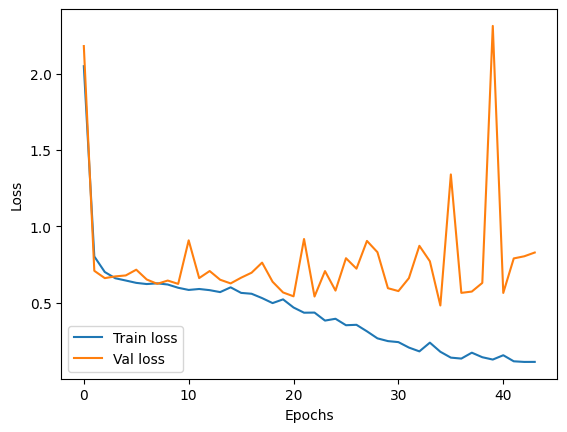

Model performance on train dataset: 
Loss: 0.3135278522968292
Accuracy: 0.8966416716575623
192/192 [==============================] - 2s 6ms/step
[[1653  180]
 [ 137 1097]]
Model performance on test dataset: 
Loss: 0.6575047373771667
Accuracy: 0.7981220483779907
54/54 [==============================] - 0s 7ms/step
[[430 100]
 [ 72 250]]


In [63]:
from matplotlib import pyplot as plt
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train loss", "Val loss"])
plt.show()

loss, acc = alexnet.evaluate(train_ds.batch(batch_size), verbose=0)
print("Model performance on train dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = alexnet.predict(train_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_train_list = list(train_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_train_list, y_pred).numpy()
print(cm)

loss, acc = alexnet.evaluate(test_ds.batch(batch_size), verbose=0)
print("Model performance on test dataset: ")
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

y_pred = alexnet.predict(test_x.batch(batch_size))
y_pred = tf.math.argmax(
    y_pred,
    axis=1)
y_test_list = list(test_y.as_numpy_iterator())
cm = tf.math.confusion_matrix(y_test_list, y_pred).numpy()
print(cm)

- These parameters worked best for the model


In [22]:
from google.colab import drive

In [23]:
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# alexnet.save("/content/drive/MyDrive/bgr-channel-alexnet.h5") # this was just using bgr channels and the performance was surprising. Image dim-250

In [25]:
# alexnet.save("/content/drive/MyDrive/bgr-overfit-surprizing-alexnet.h5") # this was an overfit model but the accuracy was amazing on both test and train data. Image dim-250

In [26]:
# alexnet.save("/content/drive/MyDrive/bgr-good-0.83-alexnet.h5") # this was an proper trained model and the accuracy is good. Image dim-400(couldn't do 500 due to RAM limit)